In [2]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [1]:
import torch
import zipfile
import kaggle
import cv2
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import ToTensor
from datetime import date

In [3]:
batch_size = 64
lr = 1e-3
epochs = 1
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

# Data processing

In [6]:
!kaggle datasets download -d balraj98/summer2winter-yosemite

100% 126M/126M [00:06<00:00, 24.5MB/s]
100% 126M/126M [00:06<00:00, 20.1MB/s]


In [7]:
f = zipfile.ZipFile("/content/summer2winter-yosemite.zip")
f.extractall("/content/imgs")

In [4]:
class HrLrImages(Dataset):
    def __init__(self, src = "/content/imgs/trainA/", transform=None):
        self.src = src
        self.transform = transform
        
        imgs = os.listdir(src)
        if not os.path.isdir(src+"low_res"):
            os.mkdir(src+"low_res")

        for i, img in enumerate(imgs):
            if img[-4:] == ".jpg":
                new_name = str(i) + ".jpg"
                os.rename(src+img, src+new_name)
                img_hr = cv2.imread(src+new_name)
                cv2.imwrite(src+"low_res/"+new_name, img_hr, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
            

    def __len__(self):
        return len(os.listdir(self.src))

    def __getitem__(self, idx):
        name = str(idx)+".jpg"
        img_hr = cv2.imread(self.src+name)
        img_lr = cv2.imread(self.src+"low_res/"+ name)

        if self.transform is not None:
            img_hr = self.transform(img_hr)
            img_lr = self.transform(img_lr)

        return img_hr, img_lr

In [9]:
dataset = HrLrImages(transform=ToTensor())

In [10]:
len(dataset)

607

In [11]:
dataloader = DataLoader(dataset, batch_size, shuffle=True)

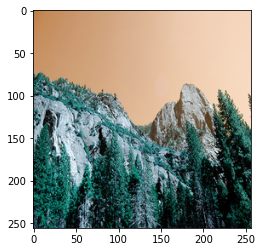

In [12]:
plt.imshow(dataset[0][0].squeeze().permute(1,2,0))

# Model structure

In [13]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder part
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=1, padding=2, dilation=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=2, dilation=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1, padding=2, dilation=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(12544, 5096),
            nn.ReLU(),
            nn.Linear(5096, 1256),
        )

        # Decoder part: the output should be a 256x256 image

        self.decoder = nn.Sequential(
            torch.nn.Linear(1256, 5096),
            torch.nn.ReLU(),
            torch.nn.Linear(5096, 256*256*3),
            torch.nn.Sigmoid()
        )

    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training part

In [15]:
def train(model, dataloader, optimizer, loss_fn):
    min_loss = 1000
    for epoch in range(epochs):
        avg_loss = 0
        print(f"======== Epoch {epoch+1} ========")
        for batch, (X, y) in enumerate(dataloader):
            if batch <= 8:
                X, y = X.to(device), y.to(device)
                y = y.view(64, -1)
                pred = model(X)
                loss = loss_fn(pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_loss += loss
        avg_loss /= 19
        print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.5f}")
        if avg_loss >= min_loss * 1.15:
            model_file_name = f"d{date.today()}l{min_loss:.5f}.pth"
            torch.save(model.state_dict(), model_file_name)
            print(f"The model was saved with the best loss: {min_loss:.5f}")
            break

In [16]:
model = AE().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [17]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1078948123

In [18]:
train(model, dataloader, optimizer, loss_fn)

======== Epoch 1 ========


OutOfMemoryError: ignored

In [21]:
d = dataset[0][0]
d.shape

torch.Size([3, 256, 256])